# Advanced Statistical Analysis & Mining 🔬

**Deep Dive into Mathematical Distributions, Inequality, and Player Clustering**

This notebook performs a rigorous statistical analysis on the OCC dataset. We go beyond basic averages to explore data topology, inequality distribution (Gini), and multivariate cluster structures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

# Setup
plt.style.use('bmh') # Bayesian Methods for Hackers style
sns.set_palette('deep')
%matplotlib inline

# Paths
DATA_DIR = Path('../data/processed')
PLOTS_DIR = Path('../plots')
PLOTS_DIR.mkdir(exist_ok=True)

print("✓ Libraries loaded and paths set!")

✓ Libraries loaded and paths set!


## 1. The 20-Metric Statistical Engine ⚙️
We define a robust function to compute 20 distinct statistical properties for any given numeric series.

In [2]:
def gini_coefficient(x):
    """Compute Gini coefficient of inequality."""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def calc_comprehensive_stats(series, name="Data"):
    """Calculate 20 advanced descriptive statistics."""
    clean_series = series.dropna()
    if len(clean_series) == 0: return {}
    
    # 1-5: Central Tendency & Spread
    mean_val = np.mean(clean_series)
    median_val = np.median(clean_series)
    std_dev = np.std(clean_series)
    variance = np.var(clean_series)
    coeff_var = std_dev / mean_val if mean_val != 0 else 0
    
    # 6-10: Shape & Range
    skew = stats.skew(clean_series)
    kurtosis = stats.kurtosis(clean_series)
    min_val = np.min(clean_series)
    max_val = np.max(clean_series)
    range_val = max_val - min_val
    
    # 11-15: Quantiles & IQR
    q25 = np.percentile(clean_series, 25)
    q75 = np.percentile(clean_series, 75)
    iqr = q75 - q25
    q99 = np.percentile(clean_series, 99)
    top_1_percent_share = clean_series[clean_series >= q99].sum() / clean_series.sum()
    
    # 16-20: Advanced/Structural
    gini = gini_coefficient(clean_series.values)
    entropy = stats.entropy(np.histogram(clean_series, bins=20)[0])
    # Normality Test (Jarque-Bera)
    jb_stat, jb_p = stats.jarque_bera(clean_series)
    is_normal = jb_p > 0.05
    # Power Law Fit (approx via log-log linearity)
    # Simple proxy: skewness > 2 usually implies heavy tail
    tail_type = "Heavy/Power" if skew > 2 else "Normal-like"
    
    return {
        'Metric': name,
        'Mean': mean_val,
        'Median': median_val,
        'Std Dev': std_dev,
        'CV (Vol)': coeff_var,
        'Skewness': skew,
        'Kurtosis': kurtosis,
        'Min': min_val,
        'Max': max_val,
        'IQR': iqr,
        '99th Pctl': q99,
        'Top 1% Share': top_1_percent_share,
        'Gini Coeff': gini,
        'Entropy': entropy,
        'Normal Dist?': is_normal,
        'Tail Type': tail_type
    }

## 2. Analyzing Individual Categories (The 3 Pillars) 🏛️
We load each dataset (Matches, PvP, Objectives) and compute stats for key activity metrics.

In [3]:
files = {
    'Matches': 'matches.json',
    'PvP': 'pvp.json',
    'Objectives': 'objectives.json'
}

stats_list = []

for category, filename in files.items():
    fpath = DATA_DIR / filename
    if fpath.exists():
        df = pd.read_json(fpath)
        
        # Select primary 'activity' metric for each
        if category == 'Matches':
            col = 'matches'
        elif category == 'PvP':
            col = 'kills'
        elif category == 'Objectives':
            col = 'wools'
            
        print(f"Processing {category} ({col})...")
        s = calc_comprehensive_stats(df[col], f"{category} - {col.title()}")
        stats_list.append(s)

# Create Summary DataFrame
summary_df = pd.DataFrame(stats_list)
print("\nCOMPREHENSIVE STATS TABLE")
print("="*80)
print(summary_df.set_index('Metric').T.round(2))

Processing Matches (matches)...
Processing PvP (kills)...
Processing Objectives (wools)...

COMPREHENSIVE STATS TABLE
Metric       Matches - Matches  PvP - Kills Objectives - Wools
Mean                  870.2734  4661.912941           39.55171
Median                   299.0       1493.5                6.0
Std Dev            1689.150865  9897.485105         135.812467
CV (Vol)              1.940943     2.123052           3.433795
Skewness              5.150229     6.039097           9.971578
Kurtosis             38.334162    53.613521         144.454313
Min                        106          455                  2
Max                      27737       161437               3005
IQR                     605.25       3371.0               17.0
99th Pctl              9076.39     49441.82             602.18
Top 1% Share          0.140221     0.158767           0.267334
Gini Coeff             0.65273     0.675439           0.802041
Entropy                0.61743     0.566256           0.301743


### insight: The Gini Coefficient
High Gini (>0.6) indicates extreme inequality. In gaming, this usually means a small 'elite' player base generates most of the activity (Kills/Wins). Is this true here?

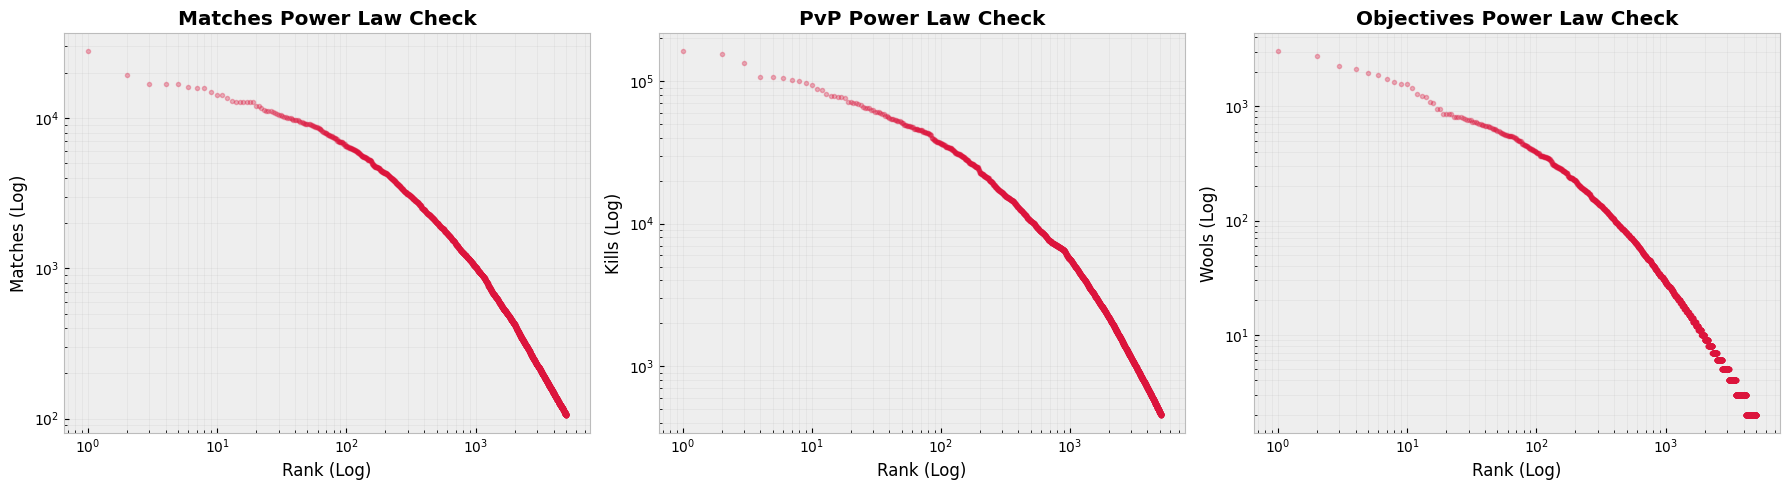

In [4]:
# Visualizing Distributions (Log Scale)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (category, filename) in enumerate(files.items()):
    df = pd.read_json(DATA_DIR / filename)
    col = 'matches' if category == 'Matches' else 'kills' if category == 'PvP' else 'wools'
    
    # Power Law Visualization (Log-Log Plot)
    # Sort data
    data = df[col].sort_values(ascending=False)
    rank = np.arange(1, len(data) + 1)
    
    ax = axes[i]
    ax.loglog(rank, data, marker='.', linestyle='none', alpha=0.3, color='crimson')
    ax.set_title(f'{category} Power Law Check', fontweight='bold')
    ax.set_xlabel('Rank (Log)')
    ax.set_ylabel(f'{col.title()} (Log)')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'power_law_check.png', dpi=300)
plt.show()

## 3. Golden Dataset: Multivariate Mining 💎
Now we look at the intersection of players. Can we reduce these 55 features into meaningful 'Player Types' using PCA?

PCA Explained Variance Ratio: [0.63848625 0.18361435]


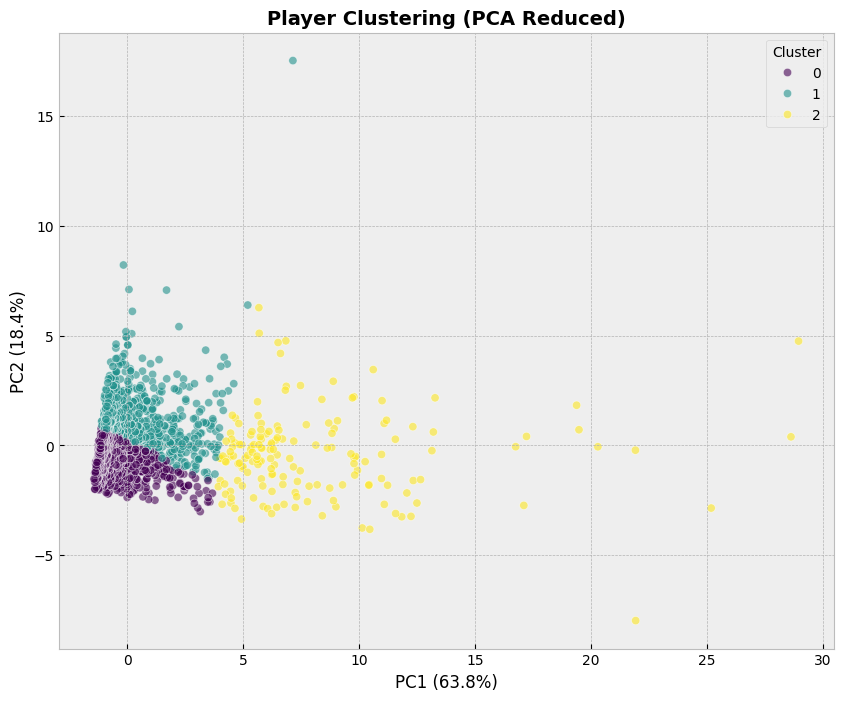

In [5]:
# Load Golden Dataset
golden_df = pd.read_parquet(DATA_DIR / 'golden_dataset.parquet')

# Select numeric feature columns only
feature_cols = [
    'matches_matches', 'wins_matches', 'wl_ratio_matches',
    'kills_pvp', 'deaths_pvp', 'kd_ratio_pvp', 
    'wools_objectives', 'cores_objectives'
]

# Prep data: create KD ratio if missing and handle NaNs
golden_df['kd_ratio_pvp'] = golden_df['kills_pvp'] / golden_df['deaths_pvp'].replace(0, 1)
X = golden_df[feature_cols].fillna(0)

# Standardize Data (Z-Score Normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA - Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
pca_df['Cluster'] = clusters

print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)

# Visualize Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.6)
plt.title('Player Clustering (PCA Reduced)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.savefig(PLOTS_DIR / 'player_clusters_pca.png', dpi=300)
plt.show()

## 4. Correlation Heatmap (Golden Dataset)
Exploring relationships between different game modes.

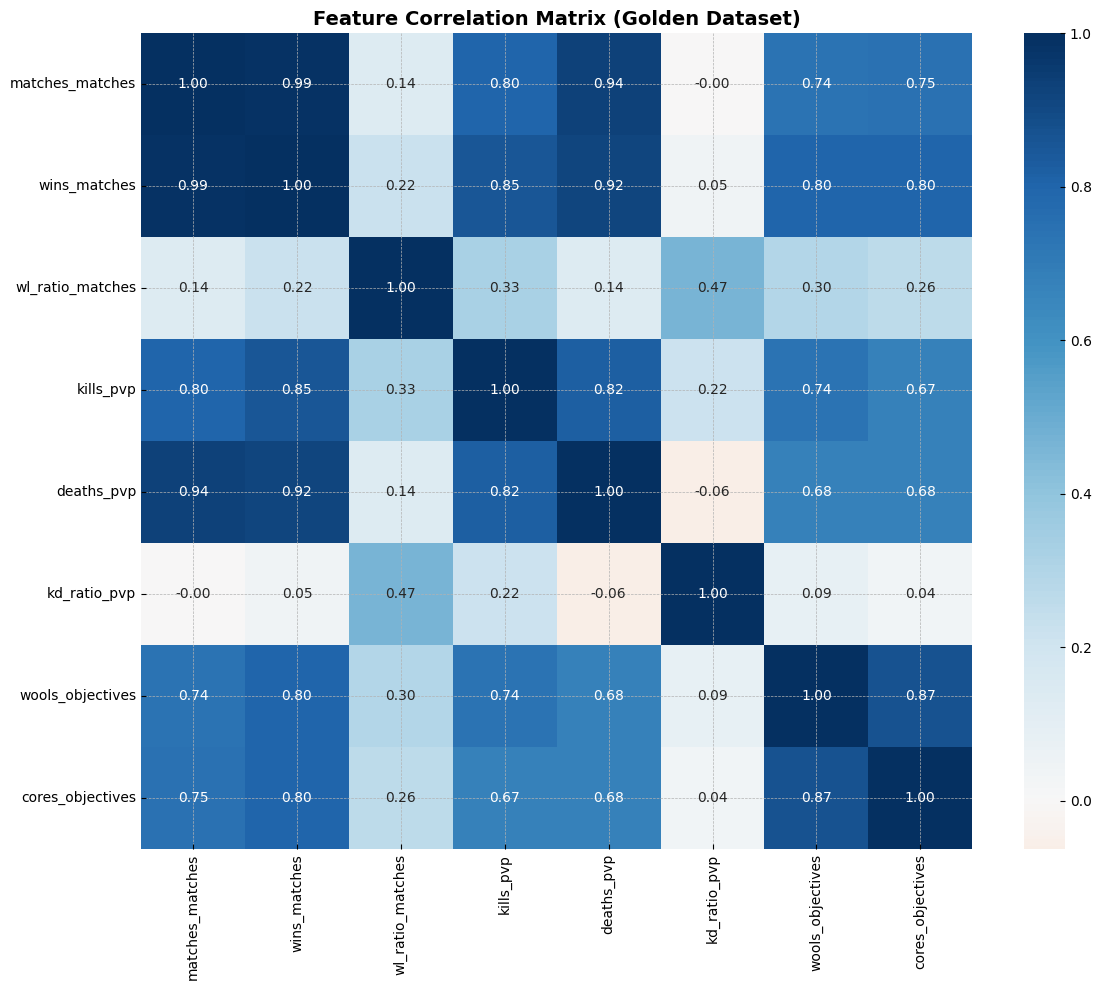

In [6]:
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='RdBu', fmt=".2f", center=0)
plt.title('Feature Correlation Matrix (Golden Dataset)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'golden_correlation_matrix.png', dpi=300)
plt.show()